# Time Series Analysis with Multi-Layer Perceptron  

Recurrent neural Network(RNN)를 사용하여 본격적으로 Sequence Modeling을 시도하기 전에,   
굳이 RNN을 사용해야만 Sequence Modeling이 가능한지 따져 보는 것이 좋겠습니다.  

이전에 다룬 ARIMA의 경우 일정한 window 사이즈만큼의 이전 타임 데이터만 보고 그 다음 올 데이터를 예측하게끔 설계하였습니다.  
그렇다면 고정 길이의 이전 타임 데이터를 입력으로 받아 그 다음 스텝의 데이터를 예측하는 Multi-Layer Perceptron을 만들어 보면 어떨까요?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# csv 포맷의 데이터 경로를 지정합니다.
dataset_filepath = 'datasets/airline-passengers.csv'

In [4]:
# csv 파일을 읽어들여 DataFrame 객체를 생성합니다.
df = pd.read_csv(dataset_filepath)

ARIMA 데이터셋과 동일하게   
앞부분 10년(1949~1958년)간의 승객수를 train-set으로 삼고,  
이후 2년(1959~1960년)간의 승객 수를 test-set으로 삼도록 하겠습니다.

하지만 time-series가 아니라 X->y로의 함수를 모델링하는 방식으로 설계되어야 하므로,  
X는 이전 5개의 연속된 달의 승객 수로 구성된 벡터, y는 그 다음 달의 승객 수로 구성합니다.

In [5]:
train_data = [([df.iat[i+j,1] for j in range(5)], df.iat[i+5,1]) for i in range(115)]

In [6]:
len(train_data)  # row 6 ~ 120 for y

115

In [7]:
train_data[0:5]

[([112, 118, 132, 129, 121], 135),
 ([118, 132, 129, 121, 135], 148),
 ([132, 129, 121, 135, 148], 148),
 ([129, 121, 135, 148, 148], 136),
 ([121, 135, 148, 148, 136], 119)]

예를 들어 첫번째 훈련데이터는 X=[112, 118, 132, 129, 121] , y=135 인 (X,y) tuple 입니다.

In [8]:
test_data = [([df.iat[i+j,1] for j in range(5)], df.iat[i+5,1]) for i in range(115, 139)]

In [9]:
test_data  # total 24 rows

[([505, 404, 359, 310, 337], 360),
 ([404, 359, 310, 337, 360], 342),
 ([359, 310, 337, 360, 342], 406),
 ([310, 337, 360, 342, 406], 396),
 ([337, 360, 342, 406, 396], 420),
 ([360, 342, 406, 396, 420], 472),
 ([342, 406, 396, 420, 472], 548),
 ([406, 396, 420, 472, 548], 559),
 ([396, 420, 472, 548, 559], 463),
 ([420, 472, 548, 559, 463], 407),
 ([472, 548, 559, 463, 407], 362),
 ([548, 559, 463, 407, 362], 405),
 ([559, 463, 407, 362, 405], 417),
 ([463, 407, 362, 405, 417], 391),
 ([407, 362, 405, 417, 391], 419),
 ([362, 405, 417, 391, 419], 461),
 ([405, 417, 391, 419, 461], 472),
 ([417, 391, 419, 461, 472], 535),
 ([391, 419, 461, 472, 535], 622),
 ([419, 461, 472, 535, 622], 606),
 ([461, 472, 535, 622, 606], 508),
 ([472, 535, 622, 606, 508], 461),
 ([535, 622, 606, 508, 461], 390),
 ([622, 606, 508, 461, 390], 432)]

Test 단계에서 주의할 점은, test_data를 위와 같이 구성했다고 해서 실제 test 시 사용해야 할 입력값은 지금 test_data를 구성하고 있는 X 값이 아니라는 것입니다. 
왜냐하면, ARIMA 테스트 시 매 스텝 prediction을 위해 test data 구간에 있는 실제 데이터를 사용한 것이 아니라 이전 스텝에서의 예측값이 다음 스텝의 예측을 위한 입력값으로 사용되었기 때문입니다.   
따라서 test 단계에서는 현재 test_data의 길이(24)만큼 반복하면서 새로운 예측값이 다음 예측을 위한 X에 반영되도록 매번 테스트 데이터를 재구성해야 합니다.

In [10]:
X_train = np.array([X for (X,y) in train_data])
X_test = np.array([X for (X,y) in test_data])

In [11]:
X_train[0:5]

array([[112, 118, 132, 129, 121],
       [118, 132, 129, 121, 135],
       [132, 129, 121, 135, 148],
       [129, 121, 135, 148, 148],
       [121, 135, 148, 148, 136]], dtype=int64)

In [12]:
len(X_train)

115

In [13]:
X_train.shape

(115, 5)

In [14]:
y_train = np.array([y for (X,y) in train_data])
y_test = np.array([y for (X,y) in test_data])

In [15]:
y_train[0:5]

array([135, 148, 148, 136, 119], dtype=int64)

In [16]:
len(y_train)

115

In [17]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [18]:
X_train.shape

(115, 5)

In [19]:
X_val = X_test
y_val = y_test

In [20]:
# to reproduce same training result
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [21]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=5))
model.add(Dense(1))
model.summary()

model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


In [67]:
# fit model
model.fit(X_train, y_train, epochs=1000, verbose=1, validation_data=(X_val, y_val))

Train on 115 samples, validate on 24 samples
Epoch 1/1000
115/115 [==============================] - 1s 5ms/step - loss: 34191.0531 - val_loss: 68335.1562
Epoch 2/1000
115/115 [==============================] - 0s 148us/step - loss: 18762.7773 - val_loss: 35574.0742
Epoch 3/1000
115/115 [==============================] - 0s 157us/step - loss: 9161.6852 - val_loss: 15168.6475
Epoch 4/1000
115/115 [==============================] - 0s 173us/step - loss: 3654.0431 - val_loss: 6176.9023
Epoch 5/1000
115/115 [==============================] - 0s 142us/step - loss: 1609.7691 - val_loss: 5223.2456
Epoch 6/1000
115/115 [==============================] - 0s 151us/step - loss: 1738.3952 - val_loss: 7236.3657
Epoch 7/1000
115/115 [==============================] - 0s 151us/step - loss: 2425.4412 - val_loss: 8438.1289
Epoch 8/1000
115/115 [==============================] - 0s 142us/step - loss: 2636.0456 - val_loss: 7746.3765
Epoch 9/1000
115/115 [==============================] - 0s 139us/step - 

115/115 [==============================] - 0s 116us/step - loss: 697.6583 - val_loss: 2223.2654
Epoch 149/1000
115/115 [==============================] - 0s 105us/step - loss: 689.6230 - val_loss: 2217.2166
Epoch 150/1000
115/115 [==============================] - 0s 110us/step - loss: 693.9138 - val_loss: 2215.0923
Epoch 151/1000
115/115 [==============================] - 0s 112us/step - loss: 690.0888 - val_loss: 2208.9185
Epoch 152/1000
115/115 [==============================] - 0s 119us/step - loss: 685.2033 - val_loss: 2204.1660
Epoch 153/1000
115/115 [==============================] - 0s 112us/step - loss: 684.1511 - val_loss: 2199.5159
Epoch 154/1000
115/115 [==============================] - 0s 117us/step - loss: 694.8402 - val_loss: 2195.8926
Epoch 155/1000
115/115 [==============================] - 0s 124us/step - loss: 684.6821 - val_loss: 2195.2825
Epoch 156/1000
115/115 [==============================] - 0s 121us/step - loss: 680.4149 - val_loss: 2191.8479
Epoch 157/1000
1

Epoch 222/1000
115/115 [==============================] - 0s 124us/step - loss: 643.8655 - val_loss: 2057.2297
Epoch 223/1000
115/115 [==============================] - 0s 113us/step - loss: 629.8131 - val_loss: 1985.0869
Epoch 224/1000
115/115 [==============================] - 0s 128us/step - loss: 628.9594 - val_loss: 2000.6836
Epoch 225/1000
115/115 [==============================] - 0s 105us/step - loss: 634.3800 - val_loss: 1979.9696
Epoch 226/1000
115/115 [==============================] - 0s 113us/step - loss: 620.6243 - val_loss: 1986.2900
Epoch 227/1000
115/115 [==============================] - 0s 116us/step - loss: 629.0987 - val_loss: 1978.6049
Epoch 228/1000
115/115 [==============================] - 0s 109us/step - loss: 619.5854 - val_loss: 1993.9414
Epoch 229/1000
115/115 [==============================] - 0s 119us/step - loss: 626.7740 - val_loss: 1985.3346
Epoch 230/1000
115/115 [==============================] - 0s 111us/step - loss: 618.0551 - val_loss: 2002.0796
E

Epoch 369/1000
115/115 [==============================] - 0s 115us/step - loss: 566.6740 - val_loss: 1764.6895
Epoch 370/1000
115/115 [==============================] - 0s 117us/step - loss: 552.3364 - val_loss: 1754.8617
Epoch 371/1000
115/115 [==============================] - 0s 120us/step - loss: 548.8625 - val_loss: 1773.3134
Epoch 372/1000
115/115 [==============================] - 0s 116us/step - loss: 555.6536 - val_loss: 1773.6967
Epoch 373/1000
115/115 [==============================] - 0s 112us/step - loss: 556.4376 - val_loss: 1750.5762
Epoch 374/1000
115/115 [==============================] - 0s 124us/step - loss: 553.7656 - val_loss: 1755.4435
Epoch 375/1000
115/115 [==============================] - 0s 127us/step - loss: 549.1343 - val_loss: 1765.9282
Epoch 376/1000
115/115 [==============================] - 0s 114us/step - loss: 561.6028 - val_loss: 1736.8326
Epoch 377/1000
115/115 [==============================] - ETA: 0s - loss: 591.853 - 0s 130us/step - loss: 559.20

Epoch 516/1000
115/115 [==============================] - 0s 118us/step - loss: 507.8546 - val_loss: 1712.5133
Epoch 517/1000
115/115 [==============================] - 0s 130us/step - loss: 495.7387 - val_loss: 1558.7594
Epoch 518/1000
115/115 [==============================] - 0s 147us/step - loss: 531.0708 - val_loss: 1556.8339
Epoch 519/1000
115/115 [==============================] - 0s 139us/step - loss: 484.2395 - val_loss: 1713.2045
Epoch 520/1000
115/115 [==============================] - 0s 122us/step - loss: 537.9391 - val_loss: 1662.8759
Epoch 521/1000
115/115 [==============================] - 0s 109us/step - loss: 514.3808 - val_loss: 1582.4834
Epoch 522/1000
115/115 [==============================] - 0s 117us/step - loss: 515.7013 - val_loss: 1564.9492
Epoch 523/1000
115/115 [==============================] - 0s 116us/step - loss: 492.9299 - val_loss: 1620.6260
Epoch 524/1000
115/115 [==============================] - 0s 115us/step - loss: 493.1266 - val_loss: 1570.1768
E

Epoch 663/1000
115/115 [==============================] - 0s 108us/step - loss: 435.5522 - val_loss: 1371.0728
Epoch 664/1000
115/115 [==============================] - 0s 105us/step - loss: 429.6634 - val_loss: 1383.2333
Epoch 665/1000
115/115 [==============================] - 0s 111us/step - loss: 432.7846 - val_loss: 1351.8890
Epoch 666/1000
115/115 [==============================] - 0s 95us/step - loss: 423.2713 - val_loss: 1325.0599
Epoch 667/1000
115/115 [==============================] - 0s 93us/step - loss: 428.0289 - val_loss: 1378.4240
Epoch 668/1000
115/115 [==============================] - 0s 108us/step - loss: 426.3205 - val_loss: 1383.7728
Epoch 669/1000
115/115 [==============================] - 0s 118us/step - loss: 425.6555 - val_loss: 1345.4010
Epoch 670/1000
115/115 [==============================] - 0s 105us/step - loss: 428.6848 - val_loss: 1313.9155
Epoch 671/1000
115/115 [==============================] - 0s 104us/step - loss: 425.4405 - val_loss: 1409.8682
Epo

Epoch 737/1000
115/115 [==============================] - 0s 101us/step - loss: 412.1355 - val_loss: 1376.5543
Epoch 738/1000
115/115 [==============================] - 0s 103us/step - loss: 397.9103 - val_loss: 1225.7631
Epoch 739/1000
115/115 [==============================] - 0s 126us/step - loss: 421.3182 - val_loss: 1224.5587
Epoch 740/1000
115/115 [==============================] - 0s 130us/step - loss: 395.9336 - val_loss: 1415.3608
Epoch 741/1000
115/115 [==============================] - 0s 113us/step - loss: 414.6423 - val_loss: 1274.7871
Epoch 742/1000
115/115 [==============================] - 0s 106us/step - loss: 396.0468 - val_loss: 1232.4144
Epoch 743/1000
115/115 [==============================] - 0s 97us/step - loss: 394.8261 - val_loss: 1263.4038
Epoch 744/1000
115/115 [==============================] - 0s 95us/step - loss: 400.4110 - val_loss: 1271.4513
Epoch 745/1000
115/115 [==============================] - 0s 96us/step - loss: 409.6052 - val_loss: 1212.0304
Epoc

115/115 [==============================] - 0s 103us/step - loss: 377.9888 - val_loss: 1133.6630
Epoch 812/1000
115/115 [==============================] - 0s 109us/step - loss: 388.6745 - val_loss: 1214.9663
Epoch 813/1000
115/115 [==============================] - 0s 113us/step - loss: 379.5815 - val_loss: 1167.5580
Epoch 814/1000
115/115 [==============================] - 0s 108us/step - loss: 368.0674 - val_loss: 1122.7321
Epoch 815/1000
115/115 [==============================] - 0s 109us/step - loss: 382.8390 - val_loss: 1199.8400
Epoch 816/1000
115/115 [==============================] - 0s 96us/step - loss: 376.3249 - val_loss: 1243.7512
Epoch 817/1000
115/115 [==============================] - 0s 103us/step - loss: 372.7828 - val_loss: 1146.7534
Epoch 818/1000
115/115 [==============================] - 0s 113us/step - loss: 372.1558 - val_loss: 1150.8785
Epoch 819/1000
115/115 [==============================] - 0s 115us/step - loss: 372.1657 - val_loss: 1219.6852
Epoch 820/1000
11

Epoch 885/1000
115/115 [==============================] - 0s 112us/step - loss: 351.8816 - val_loss: 1116.7354
Epoch 886/1000
115/115 [==============================] - 0s 99us/step - loss: 364.1697 - val_loss: 1111.4867
Epoch 887/1000
115/115 [==============================] - 0s 107us/step - loss: 351.1610 - val_loss: 1208.3644
Epoch 888/1000
115/115 [==============================] - 0s 93us/step - loss: 353.6904 - val_loss: 1034.8676
Epoch 889/1000
115/115 [==============================] - 0s 93us/step - loss: 361.4870 - val_loss: 1038.2751
Epoch 890/1000
115/115 [==============================] - 0s 99us/step - loss: 366.1109 - val_loss: 1059.9169
Epoch 891/1000
115/115 [==============================] - 0s 107us/step - loss: 373.1974 - val_loss: 1024.1053
Epoch 892/1000
115/115 [==============================] - 0s 96us/step - loss: 352.3054 - val_loss: 1325.9830
Epoch 893/1000
115/115 [==============================] - 0s 91us/step - loss: 360.1627 - val_loss: 1073.6191
Epoch 8

Epoch 959/1000
115/115 [==============================] - 0s 105us/step - loss: 327.6109 - val_loss: 1051.5748
Epoch 960/1000
115/115 [==============================] - 0s 106us/step - loss: 329.0074 - val_loss: 1012.5478
Epoch 961/1000
115/115 [==============================] - 0s 103us/step - loss: 344.4039 - val_loss: 1053.3507
Epoch 962/1000
115/115 [==============================] - 0s 98us/step - loss: 327.9537 - val_loss: 1012.1055
Epoch 963/1000
115/115 [==============================] - 0s 101us/step - loss: 329.7485 - val_loss: 1053.8893
Epoch 964/1000
115/115 [==============================] - 0s 100us/step - loss: 329.5625 - val_loss: 1037.4530
Epoch 965/1000
115/115 [==============================] - 0s 96us/step - loss: 334.3877 - val_loss: 1038.5255
Epoch 966/1000
115/115 [==============================] - 0s 95us/step - loss: 327.2498 - val_loss: 989.6514
Epoch 967/1000
115/115 [==============================] - 0s 99us/step - loss: 327.0858 - val_loss: 1029.5112
Epoch 

In [68]:
# check how exactly fit train data

y_hats = []
cur_y_hat = 0
for i in range(115):
    x_input = X_train[i]
    x_input_reshape = x_input.reshape(1,5)
    cur_y_hat = model.predict(x_input_reshape, verbose=0)
    cur_y_hat = np.squeeze(cur_y_hat)
    print('TRAIN DATA %d : predicted=%f, ground_truth=%d' % (i, cur_y_hat, y_train[i]))
    y_hats.append(cur_y_hat)

TRAIN DATA 0 : predicted=119.050171, ground_truth=135
TRAIN DATA 1 : predicted=137.650528, ground_truth=148
TRAIN DATA 2 : predicted=149.195175, ground_truth=148
TRAIN DATA 3 : predicted=151.277908, ground_truth=136
TRAIN DATA 4 : predicted=127.571175, ground_truth=119
TRAIN DATA 5 : predicted=109.729561, ground_truth=104
TRAIN DATA 6 : predicted=106.919647, ground_truth=118
TRAIN DATA 7 : predicted=119.761948, ground_truth=115
TRAIN DATA 8 : predicted=114.626312, ground_truth=126
TRAIN DATA 9 : predicted=136.498154, ground_truth=141
TRAIN DATA 10 : predicted=141.177750, ground_truth=135
TRAIN DATA 11 : predicted=134.011703, ground_truth=125
TRAIN DATA 12 : predicted=119.661057, ground_truth=149
TRAIN DATA 13 : predicted=153.819778, ground_truth=170
TRAIN DATA 14 : predicted=170.739548, ground_truth=170
TRAIN DATA 15 : predicted=158.285339, ground_truth=158
TRAIN DATA 16 : predicted=131.032196, ground_truth=133
TRAIN DATA 17 : predicted=116.789497, ground_truth=114
TRAIN DATA 18 : pred

Text(0.5, 1.0, 'RMSE: 19.7624')

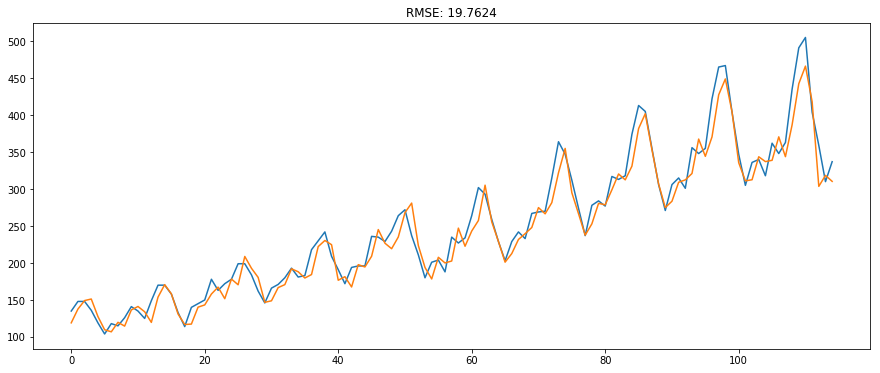

In [69]:
plt.plot(y_train)
plt.plot(y_hats)
plt.title('RMSE: %.4f'% np.sqrt(sum((y_hats-y_train)**2)/len(y_train)))

In [70]:
# predict with trained model

y_hats = []
cur_y_hat = 0
for i in range(24):
    if i == 0:  # test data 의 맨 첫번째 row에 대해서만 X 값을 그대로 활용
        x_input = X_test[0]
    else:       # 두번째 row부터는 이전 row의 prediction을 반영하여 X를 재구성
        x_input = x_input.tolist()
        del x_input[0]
        x_input.append(cur_y_hat)
        x_input = np.array(x_input)
    x_input_reshape = x_input.reshape(1,5)
    cur_y_hat = model.predict(x_input_reshape, verbose=0)
    cur_y_hat = np.squeeze(cur_y_hat)
    print('TEST DATA %d : predicted=%f, ground_truth=%d' % (i, cur_y_hat, y_test[i]))
    y_hats.append(cur_y_hat)

TEST DATA 0 : predicted=359.078796, ground_truth=360
TEST DATA 1 : predicted=352.494385, ground_truth=342
TEST DATA 2 : predicted=371.094238, ground_truth=406
TEST DATA 3 : predicted=373.598236, ground_truth=396
TEST DATA 4 : predicted=368.696014, ground_truth=420
TEST DATA 5 : predicted=377.036621, ground_truth=472
TEST DATA 6 : predicted=377.277588, ground_truth=548
TEST DATA 7 : predicted=379.830627, ground_truth=559
TEST DATA 8 : predicted=387.724823, ground_truth=463
TEST DATA 9 : predicted=391.230286, ground_truth=407
TEST DATA 10 : predicted=396.520203, ground_truth=362
TEST DATA 11 : predicted=402.468628, ground_truth=405
TEST DATA 12 : predicted=405.946777, ground_truth=417
TEST DATA 13 : predicted=410.480103, ground_truth=391
TEST DATA 14 : predicted=414.862762, ground_truth=419
TEST DATA 15 : predicted=418.557526, ground_truth=461
TEST DATA 16 : predicted=423.113281, ground_truth=472
TEST DATA 17 : predicted=427.572113, ground_truth=535
TEST DATA 18 : predicted=431.943787, g

In [71]:
y_test

array([360, 342, 406, 396, 420, 472, 548, 559, 463, 407, 362, 405, 417,
       391, 419, 461, 472, 535, 622, 606, 508, 461, 390, 432], dtype=int64)

In [72]:
y_hats

[array(359.0788, dtype=float32),
 array(352.4944, dtype=float32),
 array(371.09424, dtype=float32),
 array(373.59824, dtype=float32),
 array(368.696, dtype=float32),
 array(377.03662, dtype=float32),
 array(377.2776, dtype=float32),
 array(379.83063, dtype=float32),
 array(387.72482, dtype=float32),
 array(391.2303, dtype=float32),
 array(396.5202, dtype=float32),
 array(402.46863, dtype=float32),
 array(405.94678, dtype=float32),
 array(410.4801, dtype=float32),
 array(414.86276, dtype=float32),
 array(418.55753, dtype=float32),
 array(423.11328, dtype=float32),
 array(427.5721, dtype=float32),
 array(431.9438, dtype=float32),
 array(436.687, dtype=float32),
 array(441.2333, dtype=float32),
 array(445.73727, dtype=float32),
 array(450.32904, dtype=float32),
 array(454.79202, dtype=float32)]

Text(0.5, 1.0, 'RMSE: 84.5900')

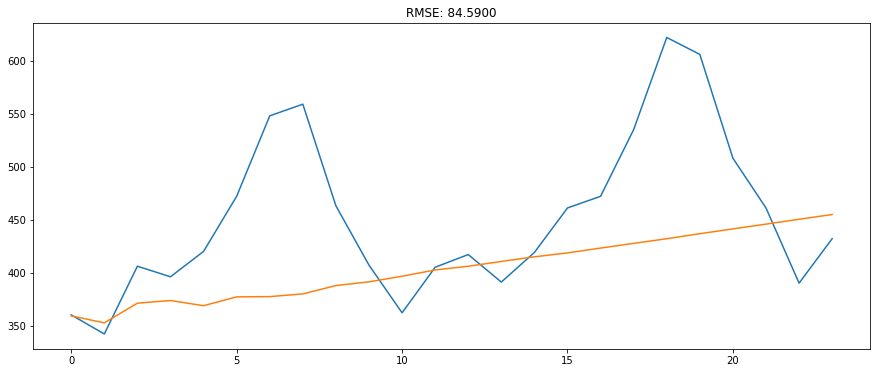

In [73]:
plt.plot(y_test)
plt.plot(y_hats)
plt.title('RMSE: %.4f'% np.sqrt(sum((y_hats-y_test)**2)/len(y_test)))